In [14]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from IPython.display import display

from disruption_survival_analysis.sweep_config import create_experiment_groups, get_experiments


from disruption_survival_analysis.plot_experiments import plot_true_alarm_rates_vs_thresholds, plot_false_alarm_rates_vs_thresholds, plot_warning_times_vs_thresholds
from disruption_survival_analysis.plot_experiments import plot_true_alarm_rates_vs_false_alarm_rates, plot_avg_warning_times_vs_false_alarm_rates


#device = 'synthetic'
#dataset_path = 'test'
device = 'cmod'
dataset_path = 'preliminary_dataset_no_ufo'

# models, alarms, metrics, and minimum warning times to use
models = ['cph', 'dsm', 'rf', 'km']
#models = ['rf']
alarms = ['sthr']
metrics = ['auroc', 'auwtc']
min_warning_times = [0.01, 0.05, 0.1, 0.2]

# Load models and create experiments
experiment_groups = create_experiment_groups(device, dataset_path, models, alarms, metrics, min_warning_times)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/configs/cph_sthr_auroc_10ms.yaml
---
Loaded model from models/cmod/preliminary_dataset_no_ufo/cph_sthr_auroc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:06:35,739] Study name was omitted but trying to load 'cph_sthr_auroc_50ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/cph_sthr_auroc_50ms_study.db
Best validation metric is 0.9236997331037824 from trial 208
---


c:\Users\zkeith\proj\disruption-survival-analysis\.venv\lib\site-packages\lifelines\utils\__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


Saved model to models/cmod/preliminary_dataset_no_ufo/cph_sthr_auroc_50ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:06:37,205] Study name was omitted but trying to load 'cph_sthr_auroc_100ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/cph_sthr_auroc_100ms_study.db
Best validation metric is 0.8812432918209829 from trial 140
---


c:\Users\zkeith\proj\disruption-survival-analysis\.venv\lib\site-packages\lifelines\utils\__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


Saved model to models/cmod/preliminary_dataset_no_ufo/cph_sthr_auroc_100ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:06:38,786] Study name was omitted but trying to load 'cph_sthr_auroc_200ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/cph_sthr_auroc_200ms_study.db
Best validation metric is 0.7519625001401324 from trial 184
---


c:\Users\zkeith\proj\disruption-survival-analysis\.venv\lib\site-packages\lifelines\utils\__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


Saved model to models/cmod/preliminary_dataset_no_ufo/cph_sthr_auroc_200ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:06:40,256] Study name was omitted but trying to load 'cph_sthr_auwtc_10ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/cph_sthr_auwtc_10ms_study.db
Best validation metric is 0.01258498210823685 from trial 21
---


c:\Users\zkeith\proj\disruption-survival-analysis\.venv\lib\site-packages\lifelines\utils\__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


Saved model to models/cmod/preliminary_dataset_no_ufo/cph_sthr_auwtc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:06:41,814] Study name was omitted but trying to load 'cph_sthr_auwtc_50ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/cph_sthr_auwtc_50ms_study.db
Best validation metric is 0.01258498210823685 from trial 0
---


c:\Users\zkeith\proj\disruption-survival-analysis\.venv\lib\site-packages\lifelines\utils\__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


Saved model to models/cmod/preliminary_dataset_no_ufo/cph_sthr_auwtc_50ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:06:43,288] Study name was omitted but trying to load 'cph_sthr_auwtc_100ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/cph_sthr_auwtc_100ms_study.db
Best validation metric is 0.01258498210823685 from trial 32
---


c:\Users\zkeith\proj\disruption-survival-analysis\.venv\lib\site-packages\lifelines\utils\__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


Saved model to models/cmod/preliminary_dataset_no_ufo/cph_sthr_auwtc_100ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:06:44,758] Study name was omitted but trying to load 'cph_sthr_auwtc_200ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/cph_sthr_auwtc_200ms_study.db
Best validation metric is 0.01258498210823685 from trial 16
---


c:\Users\zkeith\proj\disruption-survival-analysis\.venv\lib\site-packages\lifelines\utils\__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


Saved model to models/cmod/preliminary_dataset_no_ufo/cph_sthr_auwtc_200ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/configs/dsm_sthr_auroc_10ms.yaml
---
Loaded model from models/cmod/preliminary_dataset_no_ufo/dsm_sthr_auroc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:06:46,182] Study name was omitted but trying to load 'dsm_sthr_auroc_50ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/dsm_sthr_auroc_50ms_study.db
Best validation metric is 0.9734132995890425 from trial 1109
---


100%|██████████| 50/50 [01:32<00:00,  1.86s/it]
c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(


Saved model to models/cmod/preliminary_dataset_no_ufo/dsm_sthr_auroc_50ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


[I 2023-10-05 10:08:33,010] Study name was omitted but trying to load 'dsm_sthr_auroc_100ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/dsm_sthr_auroc_100ms_study.db
Best validation metric is 0.9217555398180717 from trial 419
---


100%|██████████| 50/50 [01:31<00:00,  1.82s/it]
c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(


Saved model to models/cmod/preliminary_dataset_no_ufo/dsm_sthr_auroc_100ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


[I 2023-10-05 10:10:17,723] Study name was omitted but trying to load 'dsm_sthr_auroc_200ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/dsm_sthr_auroc_200ms_study.db
Best validation metric is 0.7901120874363752 from trial 1298
---


100%|██████████| 50/50 [01:11<00:00,  1.42s/it]
c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:11:42,490] Study name was omitted but trying to load 'dsm_sthr_auwtc_10ms' because that was the only study found in the storage.


Saved model to models/cmod/preliminary_dataset_no_ufo/dsm_sthr_auroc_200ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/dsm_sthr_auwtc_10ms_study.db
Best validation metric is 0.017887238948813042 from trial 269
---


100%|██████████| 50/50 [03:35<00:00,  4.30s/it]
c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:15:31,017] Study name was omitted but trying to load 'dsm_sthr_auwtc_50ms' because that was the only study found in the storage.


Saved model to models/cmod/preliminary_dataset_no_ufo/dsm_sthr_auwtc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/dsm_sthr_auwtc_50ms_study.db
Best validation metric is 0.017709215633179787 from trial 750
---


 52%|█████▏    | 26/50 [01:30<01:23,  3.49s/it]
c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:17:15,032] Study name was omitted but trying to load 'dsm_sthr_auwtc_100ms' because that was the only study found in the storage.


Saved model to models/cmod/preliminary_dataset_no_ufo/dsm_sthr_auwtc_50ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/dsm_sthr_auwtc_100ms_study.db
Best validation metric is 0.01800345316653285 from trial 371
---


 70%|███████   | 35/50 [03:50<01:38,  6.58s/it]
c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:21:18,524] Study name was omitted but trying to load 'dsm_sthr_auwtc_200ms' because that was the only study found in the storage.


Saved model to models/cmod/preliminary_dataset_no_ufo/dsm_sthr_auwtc_100ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/dsm_sthr_auwtc_200ms_study.db
Best validation metric is 0.017858376914596418 from trial 407
---


100%|██████████| 50/50 [07:16<00:00,  8.74s/it]


Saved model to models/cmod/preliminary_dataset_no_ufo/dsm_sthr_auwtc_200ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/configs/rf_sthr_auroc_10ms.yaml
---
Loaded model from models/cmod/preliminary_dataset_no_ufo/rf_sthr_auroc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/configs/rf_sthr_auroc_50ms.yaml
---
Loaded model from models/cmod/preliminary_dataset_no_ufo/rf_sthr_auroc_50ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/configs/rf_sthr_auroc_100ms.yaml
---
Loaded model from models/cmod/preliminary_dataset_no_ufo/rf_sthr_auroc_100ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/configs/rf_sthr_auroc_200ms.yaml
---
Loaded model from models/cmod/preliminary_dataset_no_ufo/rf_sthr_auroc

c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:28:49,877] Study name was omitted but trying to load 'rf_sthr_auwtc_10ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/rf_sthr_auwtc_10ms_study.db
Best validation metric is 0.016610825404055472 from trial 3421
---
Saved model to models/cmod/preliminary_dataset_no_ufo/rf_sthr_auwtc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:31:33,148] Study name was omitted but trying to load 'rf_sthr_auwtc_50ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/rf_sthr_auwtc_50ms_study.db
Best validation metric is 0.016931366256367954 from trial 1160
---
Saved model to models/cmod/preliminary_dataset_no_ufo/rf_sthr_auwtc_50ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:33:49,648] Study name was omitted but trying to load 'rf_sthr_auwtc_100ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/rf_sthr_auwtc_100ms_study.db
Best validation metric is 0.016836017068920746 from trial 2776
---
Saved model to models/cmod/preliminary_dataset_no_ufo/rf_sthr_auwtc_100ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:35:54,739] Study name was omitted but trying to load 'rf_sthr_auwtc_200ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/rf_sthr_auwtc_200ms_study.db
Best validation metric is 0.01690682076083816 from trial 1709
---
Saved model to models/cmod/preliminary_dataset_no_ufo/rf_sthr_auwtc_200ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/configs/km_sthr_auroc_10ms.yaml
---
Loaded model from models/cmod/preliminary_dataset_no_ufo/km_sthr_auroc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:37:47,500] Study name was omitted but trying to load 'km_sthr_auroc_50ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/km_sthr_auroc_50ms_study.db
Best validation metric is 0.9714231562269684 from trial 7409
---
Saved model to models/cmod/preliminary_dataset_no_ufo/km_sthr_auroc_50ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:38:46,702] Study name was omitted but trying to load 'km_sthr_auroc_100ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/km_sthr_auroc_100ms_study.db
Best validation metric is 0.9169021192523367 from trial 2952
---
Saved model to models/cmod/preliminary_dataset_no_ufo/km_sthr_auroc_100ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:39:14,432] Study name was omitted but trying to load 'km_sthr_auroc_200ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/km_sthr_auroc_200ms_study.db
Best validation metric is 0.7845909536484772 from trial 3550
---
Saved model to models/cmod/preliminary_dataset_no_ufo/km_sthr_auroc_200ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:39:53,088] Study name was omitted but trying to load 'km_sthr_auwtc_10ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/km_sthr_auwtc_10ms_study.db
Best validation metric is 0.015595622768017446 from trial 167
---
Saved model to models/cmod/preliminary_dataset_no_ufo/km_sthr_auwtc_10ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:40:10,497] Study name was omitted but trying to load 'km_sthr_auwtc_50ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/km_sthr_auwtc_50ms_study.db
Best validation metric is 0.01598894189257309 from trial 3638
---
Saved model to models/cmod/preliminary_dataset_no_ufo/km_sthr_auwtc_50ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:42:03,170] Study name was omitted but trying to load 'km_sthr_auwtc_100ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/km_sthr_auwtc_100ms_study.db
Best validation metric is 0.016512537140538894 from trial 2043
---
Saved model to models/cmod/preliminary_dataset_no_ufo/km_sthr_auwtc_100ms.pkl
---
Attempting to load hyperparameters from yaml file...
YAML not found. Attempting to load hyperparameters from study database...


c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\experiment_utils.py:233: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(
[I 2023-10-05 10:44:54,486] Study name was omitted but trying to load 'km_sthr_auwtc_200ms' because that was the only study found in the storage.


Loaded hyperparameters for cmod/preliminary_dataset_no_ufo/studies/km_sthr_auwtc_200ms_study.db
Best validation metric is 0.016848802759622496 from trial 7333
---
Saved model to models/cmod/preliminary_dataset_no_ufo/km_sthr_auwtc_200ms.pkl


## Micro Average ROC AUC vs Horizon

See how the models perform at the individual timeslice level across the entire database.

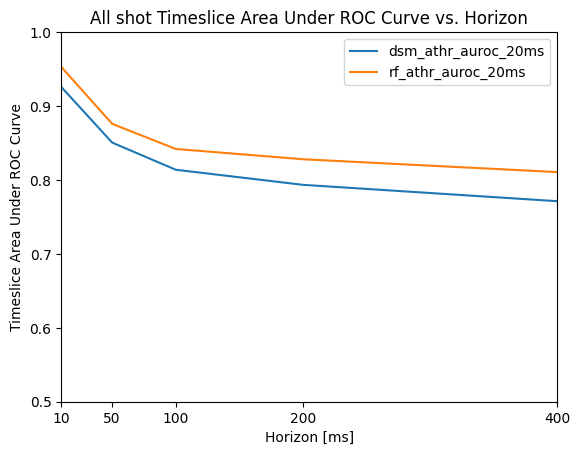

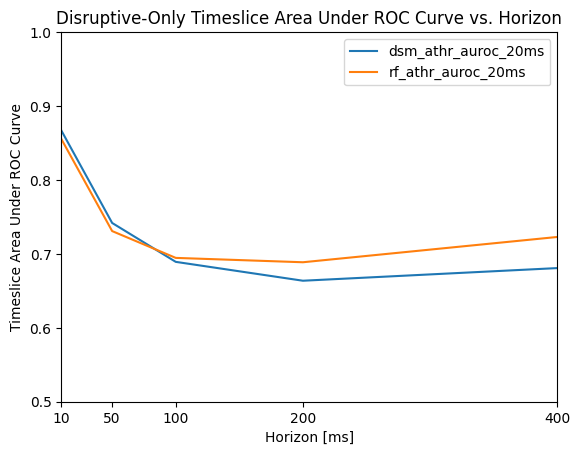

In [12]:
required_warning_time = 0.02
experiment_list = get_experiments(experiment_groups, ['dsm', 'athr', 'auroc', required_warning_time], ['rf', 'athr', 'auroc', required_warning_time])
plot_auroc_timeslice_all_vs_horizon(experiment_list, disrupt_only=False)
plot_auroc_timeslice_all_vs_horizon(experiment_list, disrupt_only=True)


## Table of Metrics:

In [4]:
result_data = []
for experiment in experiment_list:
    auroc = experiment.evaluate_metric('auroc', required_warning_time=required_warning_time)
    auwtc = experiment.evaluate_metric('auwtc', required_warning_time=required_warning_time)
    maxf1 = experiment.evaluate_metric('maxf1', required_warning_time=required_warning_time)
    tar, far, avg_warn, std_warn = experiment.max_f1_info(required_warning_time=required_warning_time)
    
    # Round to 3 sig figs
    result_array = [experiment.name, auroc, auwtc*1000, maxf1, tar, far, avg_warn*1000, std_warn*1000]
    result_data.append(result_array)
    
result_df = pd.DataFrame(result_data, columns=['Experiment Name', 'AUROC', 'AUWTC', 'Max F1', 'TAR', 'FAR', 'Avg. Warn [ms]', 'Std. Warn [ms]'])
print(f"Model Performance when Reqired Warning Time is {required_warning_time*1000} ms")
display(result_df)

Model Performance when Reqired Warning Time is 20.0 ms


,Experiment Name,AUROC,AUWTC,Max F1,TAR,FAR,Avg. Warn [ms],Std. Warn [ms]
0,dsm_sthr_auwtc_20ms,0.780912,1.770468,0.495726,0.585859,0.141805,[117.32322489372407],[184.53915974260883]
1,dsm_hyst_auwtc_20ms,0.456375,0.313719,0.279601,0.989899,0.928177,370.909084,226.772879
2,rf_sthr_auwtc_20ms,0.579422,0.000000,0.302521,0.909091,0.747698,[318.2828171987726],[217.64598712263637]
3,rf_hyst_auwtc_20ms,0.573120,0.000000,0.304132,0.929293,0.762431,316.767668,224.047152


## Threshold Plots



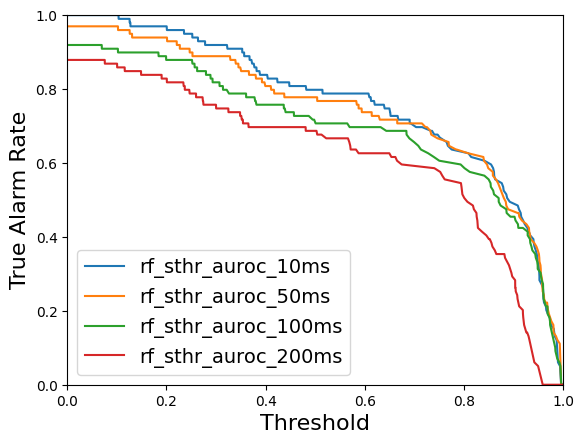

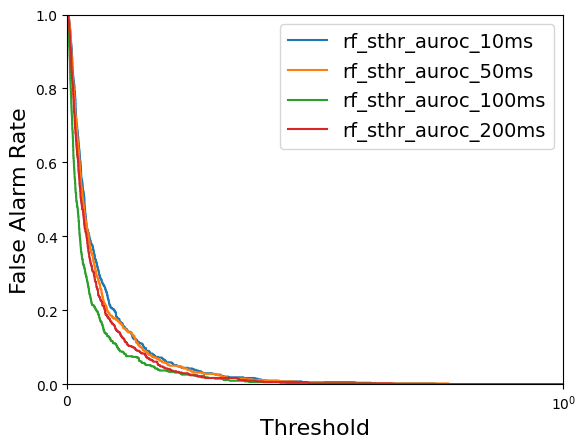

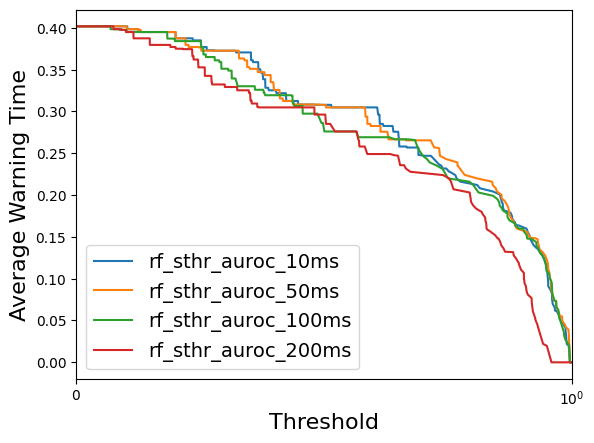

In [11]:
required_warning_time = 0.01
experiment_list = get_experiments(experiment_groups, ['auroc'])

plot_true_alarm_rates_vs_thresholds(experiment_list)
plot_false_alarm_rates_vs_thresholds(experiment_list)
plot_warning_times_vs_thresholds(experiment_list)

## ROC Curve

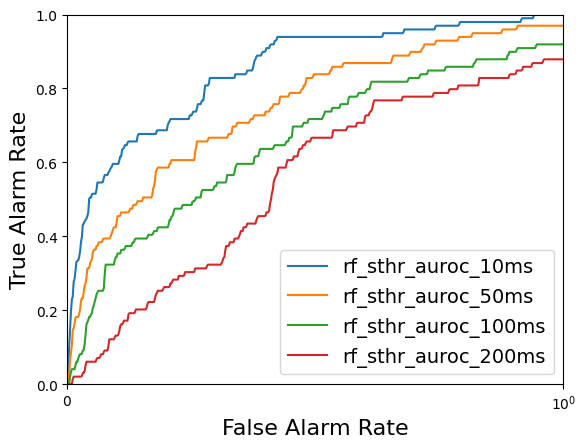

In [16]:
plot_true_alarm_rates_vs_false_alarm_rates(experiment_list)

## Area Under Warning Time Curve



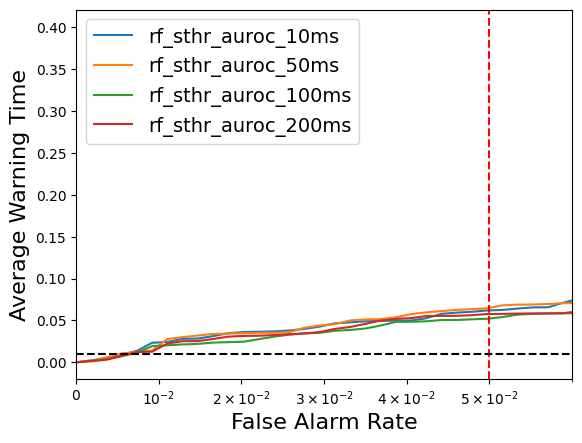

In [15]:
plot_avg_warning_times_vs_false_alarm_rates(experiment_list, required_warning_time)